## Import

In [ ]:
!pip install openpyxl

In [ ]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import math

from scipy.stats import pearsonr
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation

### 1. 지역별 수온 데이터 정리

In [ ]:
def merge_yearly_data(region: str, station_name: str, base_path: str, start_year=2018, end_year=2025):
    """
    지정한 지역과 관측소에 대해 연도별 xlsx 파일을 병합한 DataFrame을 반환.

    Parameters:
    - region (str): '부산', '전남', '강원' 등
    - station_name (str): '기장', '다대포', '장안' 등
    - base_path (str): 지역 폴더 경로 (예: '/content/.../data/월별 평균 수온/부산')
    - start_year, end_year (int): 시작/종료 연도

    Returns:
    - pd.DataFrame: 병합된 DataFrame
    """
    merged_df = pd.DataFrame()

    for year in range(start_year, end_year + 1):
        filename = f'{region}_{station_name}_{year}.xlsx'
        file_path = os.path.join(base_path, filename)

        try:
            df = pd.read_excel(file_path)

            # 날짜 형식 파싱 및 '월' 컬럼 생성
            if '관측일' in df.columns:
                df['관측일'] = pd.to_datetime(df['관측일'], errors='coerce')
                df = df.dropna(subset=['관측일'])  # 날짜 변환 실패한 행 제거
                df['월'] = df['관측일'].dt.month
            else:
                print(f"{filename} 파일에 '관측일' 컬럼이 없습니다. '월' 생성 불가.")

            df['연도'] = year
            df['지역'] = region
            df['관측소'] = station_name

            merged_df = pd.concat([merged_df, df], ignore_index=True)

        except Exception as e:
            print(f"{filename} 파일 처리 중 오류 발생: {e}")

    return merged_df

In [ ]:
busan_path = '/content/drive/MyDrive/Activities/제12회 해양수산 비즈니스･공공서비스 공모전/data/월별 평균 수온/부산'
gijang_df = merge_yearly_data('부산', '기장', busan_path)
dadaepo_df = merge_yearly_data('부산', '다대포', busan_path)
jangan_df = merge_yearly_data('부산', '장안', busan_path)

gangwon_path = '/content/drive/MyDrive/Activities/제12회 해양수산 비즈니스･공공서비스 공모전/data/월별 평균 수온/강원'
gangneung_df = merge_yearly_data('강원', '강릉', gangwon_path)
yangyang_df = merge_yearly_data('강원', '양양', gangwon_path)
samcheok_df = merge_yearly_data('강원', '삼척', gangwon_path)

jeonnam_path = '/content/drive/MyDrive/Activities/제12회 해양수산 비즈니스･공공서비스 공모전/data/월별 평균 수온/전남'
yeosu_df = merge_yearly_data('전남', '여수', jeonnam_path)
wando_df = merge_yearly_data('전남', '완도', jeonnam_path)
jindo_df = merge_yearly_data('전남', '진도', jeonnam_path)

In [ ]:
# jindo_df.tail(15)
gangneung_df.head(15)

,관측소,관측일,수층,평균 수온(℃),최고 수온(℃),최저 수온(℃),중앙 수온(℃),표준편차(℃),개수,월,연도,지역
0,강릉,2018-04-01,표층,10.9,13.4,6.8,11.1,1.5,1300,4,2018,강원
1,강릉,2018-05-01,표층,15.5,17.2,11.2,16.0,1.4,504,5,2018,강원
2,강릉,2018-06-01,표층,15.9,21.0,8.6,16.2,2.9,1430,6,2018,강원
3,강릉,2018-07-01,표층,21.2,27.4,15.2,20.6,2.0,1484,7,2018,강원
4,강릉,2018-08-01,표층,22.9,27.6,16.6,22.9,2.7,1101,8,2018,강원
5,강릉,2018-09-01,표층,22.2,23.1,20.8,22.3,0.6,740,9,2018,강원
6,강릉,2018-10-01,표층,19.3,22.0,16.2,19.6,1.3,1402,10,2018,강원
7,강릉,2018-11-01,표층,16.3,18.1,13.9,16.4,0.9,983,11,2018,강원
8,강릉,2018-12-01,표층,13.0,14.7,11.7,12.9,0.7,1455,12,2018,강원
9,강릉,2019-01-01,표층,11.9,13.1,9.9,11.9,0.6,1471,1,2019,강원


In [ ]:
def create_region_average(df_list, region_name):
    """
    여러 관측소의 수온 데이터를 평균내어 지역별 대표 수온 데이터를 생성.

    Parameters:
    - df_list (list): 같은 지역의 관측소 데이터프레임 리스트
    - region_name (str): 지역 이름 (예: '부산')

    Returns:
    - pd.DataFrame: 지역별 월 평균 수온 데이터프레임
    """
    # 필요한 컬럼만 추출 (연도, 월, 평균수온 등)
    selected_cols = ['연도', '월', '평균 수온(℃)', '최고 수온(℃)', '최저 수온(℃)', '중앙 수온(℃)', '표준편차(℃)']
    dfs = [df[selected_cols] for df in df_list]

    # 각 관측소의 데이터프레임을 concat 후, 그룹화하여 평균
    merged = pd.concat(dfs)
    region_avg = merged.groupby(['연도', '월']).mean().reset_index()

    # 지역 이름 명시
    region_avg['지역'] = region_name

    # 컬럼 순서 정렬
    cols = ['지역', '연도', '월'] + [col for col in region_avg.columns if col not in ['지역', '연도', '월']]
    region_avg = region_avg[cols]

    return region_avg

In [ ]:
# 평균 수온 데이터프레임 생성
busan_avg_df = create_region_average([dadaepo_df, gijang_df, jangan_df], '부산')
gangwon_avg_df = create_region_average([gangneung_df, yangyang_df, samcheok_df], '강원')
jeonnam_avg_df = create_region_average([yeosu_df, wando_df, jindo_df], '전남')

In [ ]:
busan_avg_df.head(20)

,지역,연도,월,평균 수온(℃),최고 수온(℃),최저 수온(℃),중앙 수온(℃),표준편차(℃)
0,부산,2018,4,13.200000,14.933333,12.000000,13.133333,0.666667
1,부산,2018,5,15.266667,18.900000,12.800000,14.933333,1.466667
2,부산,2018,6,18.400000,21.933333,14.433333,18.533333,1.600000
3,부산,2018,7,21.766667,27.766667,16.200000,21.600000,2.400000
4,부산,2018,8,25.533333,29.366667,15.966667,26.600000,2.766667
5,부산,2018,9,22.333333,25.500000,18.000000,22.400000,1.200000
6,부산,2018,10,19.900000,22.666667,15.500000,19.900000,1.533333
7,부산,2018,11,16.933333,20.433333,14.733333,16.866667,0.966667
8,부산,2018,12,14.866667,18.233333,11.966667,14.766667,1.066667
9,부산,2019,1,13.300000,16.333333,10.866667,13.333333,1.000000


In [ ]:
def clean_column_names(df):
    rename_map = {
        '평균 수온(℃)': '평균 수온',
        '최고 수온(℃)': '최고 수온',
        '최저 수온(℃)': '최저 수온',
        '중앙 수온(℃)': '중앙 수온',
        '표준편차(℃)': '표준편차'
    }
    df.columns = df.columns.str.strip().str.replace('\n', '', regex=False)
    df.rename(columns=rename_map, inplace=True)
    return df

clean_column_names(busan_avg_df)
clean_column_names(gangwon_avg_df)
clean_column_names(jeonnam_avg_df)

,지역,연도,월,평균 수온,최고 수온,최저 수온,중앙 수온,표준편차
0,전남,2018,4,13.300000,15.366667,11.766667,13.166667,0.800000
1,전남,2018,5,16.133333,18.433333,14.466667,16.166667,1.066667
2,전남,2018,6,19.566667,21.666667,17.600000,19.500000,0.966667
3,전남,2018,7,23.200000,27.066667,20.466667,23.300000,1.400000
4,전남,2018,8,25.433333,27.366667,23.200000,25.366667,0.833333
...,...,...,...,...,...,...,...,...
80,전남,2024,12,11.466667,14.366667,8.966667,11.300000,1.533333
81,전남,2025,1,8.633333,9.900000,7.233333,8.633333,0.600000
82,전남,2025,2,6.966667,8.666667,5.500000,6.933333,0.566667
83,전남,2025,3,8.500000,10.466667,6.566667,8.500000,0.933333


In [ ]:
print(busan_avg_df.columns)
print(gangwon_avg_df.columns)
print(jeonnam_avg_df.columns)

Index(['지역', '연도', '월', '평균 수온', '최고 수온', '최저 수온', '중앙 수온', '표준편차'], dtype='object')
Index(['지역', '연도', '월', '평균 수온', '최고 수온', '최저 수온', '중앙 수온', '표준편차'], dtype='object')
Index(['지역', '연도', '월', '평균 수온', '최고 수온', '최저 수온', '중앙 수온', '표준편차'], dtype='object')


In [ ]:
temp_final_df = pd.concat([busan_avg_df, gangwon_avg_df, jeonnam_avg_df], ignore_index=True)

temp_final_df = temp_final_df.rename(columns={
    '지역': 'region',
    '연도': 'year',
    '월': 'month',
    '평균 수온': 'avg_temp',
    '최고 수온': 'max_temp',
    '최저 수온': 'min_temp',
    '중앙 수온': 'median_temp',
    '표준편차': 'std_temp'
})

temp_final_df.head(15)

,region,year,month,avg_temp,max_temp,min_temp,median_temp,std_temp
0,부산,2018,4,13.200000,14.933333,12.000000,13.133333,0.666667
1,부산,2018,5,15.266667,18.900000,12.800000,14.933333,1.466667
2,부산,2018,6,18.400000,21.933333,14.433333,18.533333,1.600000
3,부산,2018,7,21.766667,27.766667,16.200000,21.600000,2.400000
4,부산,2018,8,25.533333,29.366667,15.966667,26.600000,2.766667
5,부산,2018,9,22.333333,25.500000,18.000000,22.400000,1.200000
6,부산,2018,10,19.900000,22.666667,15.500000,19.900000,1.533333
7,부산,2018,11,16.933333,20.433333,14.733333,16.866667,0.966667
8,부산,2018,12,14.866667,18.233333,11.966667,14.766667,1.066667
9,부산,2019,1,13.300000,16.333333,10.866667,13.333333,1.000000


In [ ]:
# temp_final_df.to_csv('/content/drive/MyDrive/Activities/제12회 해양수산 비즈니스･공공서비스 공모전/data/temp_final.csv', index=False)

### 2. 어획량 데이터 정리

In [ ]:
fish_df = pd.read_csv('/content/drive/MyDrive/Activities/제12회 해양수산 비즈니스･공공서비스 공모전/data/어업생산동향조사_어업별_품종별_통계.csv')

# 첫 번째 행 제거
fish_df = fish_df.iloc[1:16]

# 주요 컬럼 이름 정리
fish_df.rename(columns={
    '품종별': 'species',
    '행정구역별': 'region'
}, inplace=True)

# 컬럼명 중 '2024.01 p)'와 같이 잠정값 명시를 위해 ' p)'가 붙은 컬럼들에 대해 ' p)'를 이름에서 제외하도록 변경
fish_df.columns = fish_df.columns.str.replace(' p)', '')

# 불필요한 컬럼 정리
fish_df.drop(columns=['어업별', '판매형태별'], inplace=True)

# region 컬럼의 값들에 대해서 '부산광역시'는 '부산'으로, '강원도'는 '강원'으로, '전라남도'는 '전남'으로 변경
region_map = {'부산광역시': '부산', '강원도': '강원', '전라남도': '전남'}
fish_df['region'] = fish_df['region'].map(region_map)

# species 컬럼의 값 중 '망치고등어'와 '갑오징어류'는 삭제하고, '살오징어(오징어)'는 '오징어'로 이름 변경
fish_df = fish_df[~fish_df['species'].isin(['망치고등어', '갑오징어류'])]
fish_df['species'] = fish_df['species'].replace({'살오징어(오징어)': '오징어'})

fish_df.columns = fish_df.columns.str.strip()

fish_df.head(20)

,species,region,2018.04,2018.05,2018.06,2018.07,2018.08,2018.09,2018.10,2018.11,...,2024.07,2024.08,2024.09,2024.10,2024.11,2024.12,2025.01,2025.02,2025.03,2025.04
1,갈치,부산,652,30,208,388,281,762,524,638,...,104,373,357,1020,1077,1290,1393,178,56,23
2,갈치,강원,-,-,-,-,-,0,-,-,...,-,-,-,-,-,-,-,-,-,-
3,갈치,전남,476,189,720,401,1046,1265,1536,1398,...,186,1182,657,1157,1714,1526,856,134,260,278
4,고등어,부산,2765,2,89,7950,10699,18763,15213,18957,...,6155,9468,16072,14873,14878,3594,17012,5005,7281,6410
5,고등어,강원,0,6,11,627,1633,1904,219,443,...,91,247,335,367,121,589,494,15,33,0
6,고등어,전남,60,18,18,13,141,195,162,112,...,289,96,624,1155,648,39,279,189,233,293
13,오징어,부산,1,22,105,1231,1516,2119,3042,640,...,240,603,729,250,42,58,103,26,50,1
14,오징어,강원,1,258,386,125,151,602,1292,192,...,160,28,29,171,51,90,154,2,0,-
15,오징어,전남,7,6,14,527,666,932,217,6,...,121,477,559,200,15,1,14,1,6,2


In [ ]:
# wide → long 변환
fish_long = fish_df.melt(
    id_vars=['species', 'region'],  # ‘species’와 ‘region’은 고정하고, 나머지 2023.01, 2023.02 같은 컬럼들을 행으로 펼쳐줌
    var_name='년월',  # melt 이후 새로 생기는 컬럼의 이름. 해당 행이 어떤 시점의 데이터를 나타내는가를 나타냄.
    value_name='catch_ton'  # melt로 인해 열 값들이 줄어들면서 그 각 시점의 실제 어획량 데이터가 하나의 열에 저장되고, 그 컬럼의 이름
)

# '년월'을 'year'와 'month'로 분리
fish_long[['year', 'month']] = fish_long['년월'].str.split('.', expand=True)
fish_long['year'] = fish_long['year'].astype(int)
fish_long['month'] = fish_long['month'].astype(int)

# 이제 '년월' 컬럼은 필요 없으므로 삭제
fish_long.drop(columns='년월', inplace=True)

# 컬럼 순서 정리
fish_long = fish_long[['region', 'year', 'month', 'species', 'catch_ton']]

In [ ]:
fish_long.head(20)
fish_long.tail(20)

,region,year,month,species,catch_ton
745,강원,2025,2,오징어,2
746,전남,2025,2,오징어,1
747,부산,2025,3,갈치,56
748,강원,2025,3,갈치,-
749,전남,2025,3,갈치,260
750,부산,2025,3,고등어,7281
751,강원,2025,3,고등어,33
752,전남,2025,3,고등어,233
753,부산,2025,3,오징어,50
754,강원,2025,3,오징어,0


In [ ]:
fish_final_df = fish_long.copy()

# fish_final_df.to_csv('/content/drive/MyDrive/Activities/제12회 해양수산 비즈니스･공공서비스 공모전/data/fish_final.csv', index=False)

### 3. 수온 & 어획량 데이터 병합

In [ ]:
# 병합 (inner join으로 공통된 날짜/지역만 유지)
merged_df = pd.merge(fish_final_df, temp_final_df, on=['region', 'year', 'month'], how='inner')

# 컬럼 순서 정리 (선택사항)
cols = ['region', 'year', 'month', 'species', 'catch_ton'] + \
       [col for col in merged_df.columns if col not in ['region', 'year', 'month', 'species', 'catch_ton']]
merged_df = merged_df[cols]

# 확인
print(merged_df.head())
print(f"병합된 데이터셋 shape: {merged_df.shape}")

  region  year  month species catch_ton  avg_temp   max_temp   min_temp  \
0     부산  2018      4      갈치       652      13.2  14.933333  12.000000   
1     강원  2018      4      갈치         -      10.8  14.000000   5.500000   
2     전남  2018      4      갈치       476      13.3  15.366667  11.766667   
3     부산  2018      4     고등어      2765      13.2  14.933333  12.000000   
4     강원  2018      4     고등어         0      10.8  14.000000   5.500000   

   median_temp  std_temp  
0    13.133333  0.666667  
1    10.700000  1.666667  
2    13.166667  0.800000  
3    13.133333  0.666667  
4    10.700000  1.666667  
병합된 데이터셋 shape: (765, 10)


In [ ]:
# region & species 영문 매핑
region_map = {
    '부산': 'busan',
    '강원': 'gangwon',
    '전남': 'jeonnam'
}

species_map = {
    '갈치': 'hairtail',
    '고등어': 'mackerel',
    '오징어': 'squid'
}

merged_df['region'] = merged_df['region'].map(region_map)
merged_df['species'] = merged_df['species'].map(species_map)

In [ ]:
merged_df.head()

,region,year,month,species,catch_ton,avg_temp,max_temp,min_temp,median_temp,std_temp
0,busan,2018,4,hairtail,652,13.2,14.933333,12.000000,13.133333,0.666667
1,gangwon,2018,4,hairtail,-,10.8,14.000000,5.500000,10.700000,1.666667
2,jeonnam,2018,4,hairtail,476,13.3,15.366667,11.766667,13.166667,0.800000
3,busan,2018,4,mackerel,2765,13.2,14.933333,12.000000,13.133333,0.666667
4,gangwon,2018,4,mackerel,0,10.8,14.000000,5.500000,10.700000,1.666667


In [ ]:
# merged_df.to_csv('/content/drive/MyDrive/Activities/제12회 해양수산 비즈니스･공공서비스 공모전/data/final_merged.csv', index=False)

## Preprocessing

### 결측치 처리

In [ ]:
merged_df.isnull().sum()

,0
region,0
year,0
month,0
species,0
catch_ton,0
avg_temp,0
max_temp,0
min_temp,0
median_temp,0
std_temp,0


In [ ]:
merged_df.dtypes

,0
region,object
year,int64
month,int64
species,object
catch_ton,object
avg_temp,float64
max_temp,float64
min_temp,float64
median_temp,float64
std_temp,float64


In [ ]:
merged_df['catch_ton'] = pd.to_numeric(merged_df['catch_ton'], errors='coerce')

In [ ]:
merged_df.isnull().sum()

,0
region,0
year,0
month,0
species,0
catch_ton,69
avg_temp,0
max_temp,0
min_temp,0
median_temp,0
std_temp,0


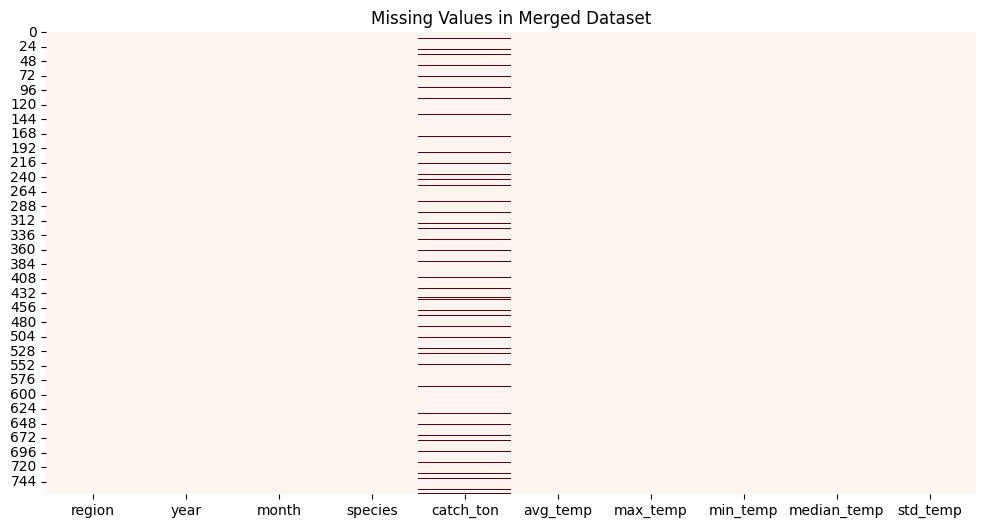

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(merged_df.isna(), cbar=False, cmap="Reds")
plt.title("Missing Values in Merged Dataset")
plt.show()

In [ ]:
missing_info = merged_df[merged_df['catch_ton'].isna()]
missing_counts = missing_info.groupby(['species', 'region']).size().reset_index(name='missing_count')
print(missing_counts)

    species   region  missing_count
0  hairtail  gangwon             67
1     squid  gangwon              2


In [ ]:
merged_df['catch_ton'] = merged_df['catch_ton'].fillna(0)

merged_df.isnull().sum()

,0
region,0
year,0
month,0
species,0
catch_ton,0
avg_temp,0
max_temp,0
min_temp,0
median_temp,0
std_temp,0


## Analysing (EDA)

### 1. 지역・시기별 수온 변화 추세 시각화

- 목표: 전체적인 수온 변화 흐름을 파악하기 위한 기초 작업
    - 연월별 평균 수온 변화 패턴
    - 지역별 수온 추세 차이

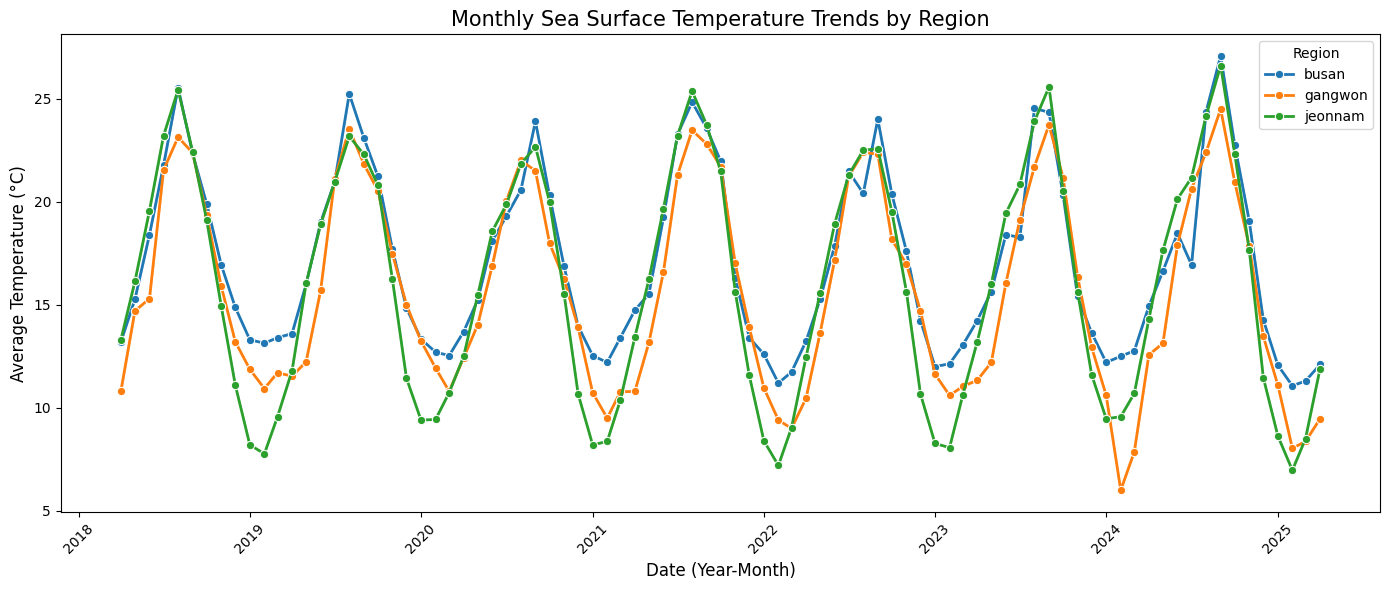

In [ ]:
# datetime 객체 생성
merged_df['date'] = pd.to_datetime(merged_df[['year', 'month']].assign(day=1))

# 시각화
plt.figure(figsize=(14, 6))
sns.lineplot(
    data=merged_df, x='date', y='avg_temp',
    hue='region', marker='o', linewidth=2
)

plt.title('Monthly Sea Surface Temperature Trends by Region', fontsize=15)  # 지역별 월간 표층수온 변화 추세
plt.xlabel('Date (Year-Month)', fontsize=12)  # 날짜 (연-월)
plt.ylabel('Average Temperature (°C)', fontsize=12)  # 평균 수온 (섭씨)
plt.xticks(rotation=45)
plt.legend(title='Region')
plt.tight_layout()
plt.show()

**분석**:

- 수온 변화 추세의 계절성과 지역 간 수온 차이가 잘 드러남

- 단, 6~7년 치 데이터로는 기후변화의 장기적인 상승세를 말하기 어렵기 때문에 단기적인 fluctuation이나 반복 패턴 정도만 참고

- **양극화 느낌**: 예컨대 여름철 수온은 점점 더 높아지고, 겨울철 수온은 점점 더 떨어지는 경향이 있어 보임 ⇒ **수온 변화의 폭이 커지고 있다**!

- **지역별 수온 범위 차이**:
    - 강원(gangwon) 지역의 경우 여름엔 낮고 겨울엔 확실히 낮음 (북부)
    - 부산(busan)과 전남(jeonnam) 지역의 경우 전반적으로 높고, 여름철 극댓값도 떠 뚜렷함 (남부)

---

**결론**:

- 위 그래프에 나타난 계절성과 지역차를 기반으로 어획량 역시 이 시기적・지역적 수온 차이에 따라 얼마나 영향을 받는지를 다음 단계에서 검토

- 특히 어종별 서식(조업) 수온대역이 있다면, 그 수온에 맞춰서 출현 시기와 위치가 바뀌는지를 볼 수 있을 것으로 예상됨

### 2. 어종별 수온 분포 시각화

- 목표: 각 어종이 주로 어떤 수온대에 나타나는지 (어종별 선호하는 수온대가 있는지) 시각화
    - 커널 밀도 추정(KDE)으로 확인
    - 서식 적정 수온대 파악

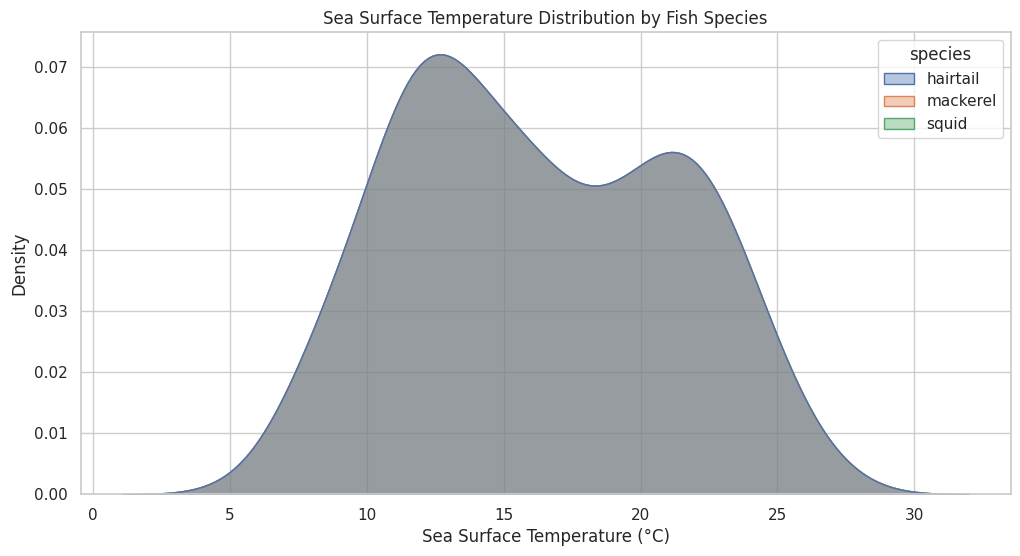

In [ ]:
# 시각화 스타일 설정
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# 어종별 수온 분포 시각화
sns.kdeplot(data=merged_df, x="avg_temp", hue="species", common_norm=False, fill=True, alpha=0.4)

plt.title("Sea Surface Temperature Distribution by Fish Species")  # 어종별 수온 분포
plt.xlabel("Sea Surface Temperature (°C)")  # 수온
plt.ylabel("Density")  # 밀도
plt.show()

→ 수온(avg_temp)은 지역・시기별로 고정된 값인데, 어종(species)은 해당 수온에 따라 중복 기록됨 (같은 수온에 여러 어종 존재 가능). 결국 수온 분포 KDE를 어종 기준으로 그리면 동일 수온값들이 여러 번 중복돼서 왜곡됨.

즉, 어종마다 서식 수온이 달라서 다른 밀도 분포를 보이기를 기대하지만, 실제 데이터 구조상 같은 수온이 여러 어종에 복붙된 형태이기 때문에, 제대로 된 KDE 분포는 나오지 않는 것.

⇒ **어획량까지 포함해서 “어종별 어획량이 많이 나오는 수온대”를 분석하는 형태로 수정**

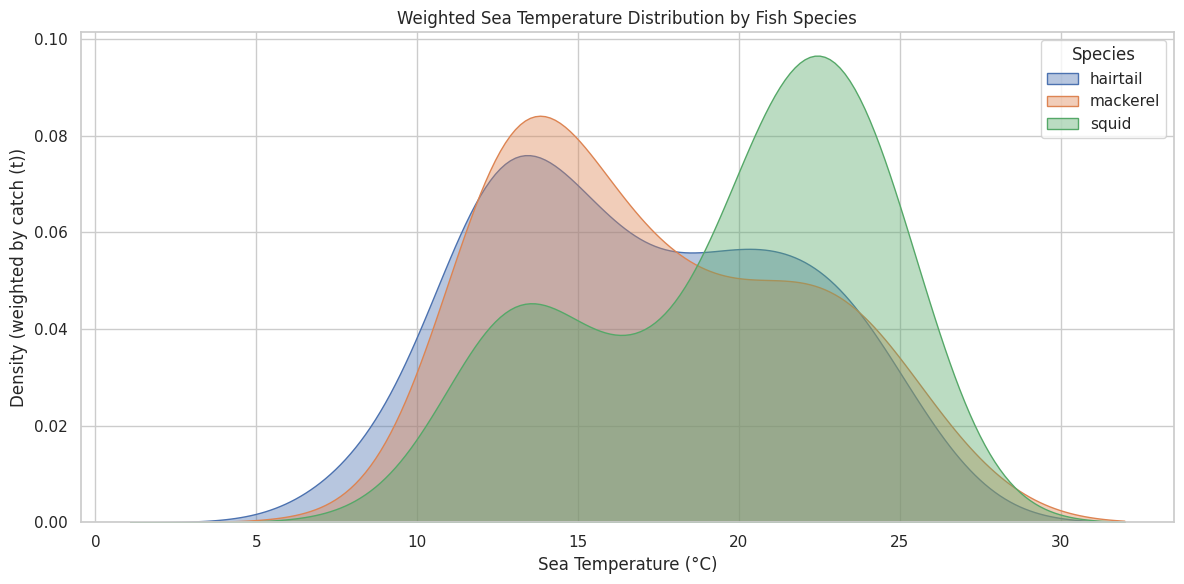

In [ ]:
# 어획량을 weight로 사용하는 KDE
plt.figure(figsize=(12, 6))
for species in merged_df["species"].unique():
    subset = merged_df[merged_df["species"] == species]
    sns.kdeplot(
        data=subset,
        x="avg_temp",
        weights=subset["catch_ton"],
        label=species,
        fill=True,
        alpha=0.4
    )

plt.title("Weighted Sea Temperature Distribution by Fish Species")
plt.xlabel("Sea Temperature (°C)")
plt.ylabel("Density (weighted by catch (t))")
plt.legend(title="Species")
plt.tight_layout()
plt.show()

**분석**:

- **갈치 (hairtail)**
    - 주요 분포: 약 **12~15°C** 부근에서 밀도 최고치
    - 해석: 갈치는 **비교적 낮은 수온대**에서 주로 어획됨
    - 확산도: 약간 분산돼 있지만 전체적으로 **10~20°C**에 많이 분포

- **고등어 (mackerel)**
    - 주요 분포: **13~16°C** 부근에서 피크
    - 해석: 갈치와 비슷하게 **서늘한 수온**을 선호
    - 특이점: 갈치보다 약간 좁은 범위에 몰려 있고, **피크가 더 뾰족**함

- **오징어 (squid)**
    - 주요 분포: **22~25°C**에서 강한 밀도 피크
    - 해석: 오징어는 확실히 **따뜻한 수온대**에서 어획되는 특성이 강함
    - 확산도: 분포가 넓고, 일부는 **10~15°C** 부근에서도 소량 분포

---

**결론**:

- **어종별 수온 선호도와 어획량 집중 구간 확인**

### 3. 수온과 어획량 간 상관관계 분석

- 목표: 수온이 어획량에 어떤 영향을 주는지 확인

#### **단순 상관 분석**

- 이때 피어슨 상관계수가 의미하는 바가 '선형 관계가 어느 정도 존재하는지'이긴 하지만, 이는 경향을 말할 뿐 인과 관계를 반드시 보장하지는 않음. 상관계수는 '두 변수가 얼마나 함께 움직이는가'를 수치로 표현한 것.
- 예컨대 수온이 어획량의 직접 원인이 아닐 수도 있음
- 데이터를 기반으로 봤을 때 그러한 선형 관계가 자주 관측된다는 의미

##### 1) **pearsonr() 함수로 상관계수와 p-value 계산**

- 어종・지역별 수온과 어획량 상관관계의 통계적 유의성 판단
- p-value < 0.05면 통계적으로 유의미하다고 말함 (95% 신뢰수준)



In [ ]:
def calc_corr_with_pvalue(df, species):
    """
    주어진 어종(species)에 대해 지역별로 수온과 어획량 간의 Pearson 상관계수와 p-value를 계산하는 함수.
    """
    results = {}
    species_df = df[df['species'] == species]

    for region in species_df['region'].unique():    # 'busan', 'gangwon', 'jeonnam'
        region_df = species_df[species_df['region'] == region]
        grouped = region_df.groupby('date')[['avg_temp', 'catch_ton']].mean()

        # 결측치 있는 경우 제외
        grouped = grouped.dropna()

        corr, pval = pearsonr(grouped['avg_temp'], grouped['catch_ton'])
        results[region] = {
            'corr': round(corr, 3),
            'pval': round(pval, 5)
        }

    return results

In [ ]:
print("갈치: ", calc_corr_with_pvalue(merged_df, 'hairtail'))
print("\n고등어: ", calc_corr_with_pvalue(merged_df, 'mackerel'))
print("\n오징어: ", calc_corr_with_pvalue(merged_df, 'squid'))

갈치:  {'busan': {'corr': np.float64(-0.217), 'pval': np.float64(0.04657)}, 'gangwon': {'corr': np.float64(0.111), 'pval': np.float64(0.31303)}, 'jeonnam': {'corr': np.float64(0.434), 'pval': np.float64(3e-05)}}

고등어:  {'busan': {'corr': np.float64(0.059), 'pval': np.float64(0.59058)}, 'gangwon': {'corr': np.float64(0.333), 'pval': np.float64(0.00184)}, 'jeonnam': {'corr': np.float64(0.018), 'pval': np.float64(0.86697)}}

오징어:  {'busan': {'corr': np.float64(0.495), 'pval': np.float64(0.0)}, 'gangwon': {'corr': np.float64(0.221), 'pval': np.float64(0.04208)}, 'jeonnam': {'corr': np.float64(0.585), 'pval': np.float64(0.0)}}


In [ ]:
def pretty_corr_results(results):
    for species, region in results.items():
        print(f"\n{species.upper()}")

        for region, values in region.items():
            corr = round(float(values['corr']), 3) if values['corr'] != None else "N/A"
            pval = round(float(values['pval']), 5) if values['pval'] != None else "N/A"
            significance = "✅ 유의" if isinstance(pval, float) and pval < 0.05 else "⚠️ 불확실"

            print(f"- {region}: 상관계수 = {corr}, p-value = {pval} → {significance}")

In [ ]:
results_all = {
    'hairtail': calc_corr_with_pvalue(merged_df, 'hairtail'),
    'mackerel': calc_corr_with_pvalue(merged_df, 'mackerel'),
    'squid': calc_corr_with_pvalue(merged_df, 'squid')
}

pretty_corr_results(results_all)


HAIRTAIL
- busan: 상관계수 = -0.217, p-value = 0.04657 → ✅ 유의
- gangwon: 상관계수 = 0.111, p-value = 0.31303 → ⚠️ 불확실
- jeonnam: 상관계수 = 0.434, p-value = 3e-05 → ✅ 유의

MACKEREL
- busan: 상관계수 = 0.059, p-value = 0.59058 → ⚠️ 불확실
- gangwon: 상관계수 = 0.333, p-value = 0.00184 → ✅ 유의
- jeonnam: 상관계수 = 0.018, p-value = 0.86697 → ⚠️ 불확실

SQUID
- busan: 상관계수 = 0.495, p-value = 0.0 → ✅ 유의
- gangwon: 상관계수 = 0.221, p-value = 0.04208 → ✅ 유의
- jeonnam: 상관계수 = 0.585, p-value = 0.0 → ✅ 유의


##### 2) **회귀선 시각화**

- 지역・어종별 회귀선 시각화: 지역별 + 어종별로 필터링한 다음, 같은 지역・어종에 속한 여러 연월의 데이터를 각각 (수온, 어획량) 쌍으로 놓고 회귀선 그림
- 각 지역-어종 조합에 대한 산점도 + 회귀선 출력
- x축: 수온, y축: 어획량

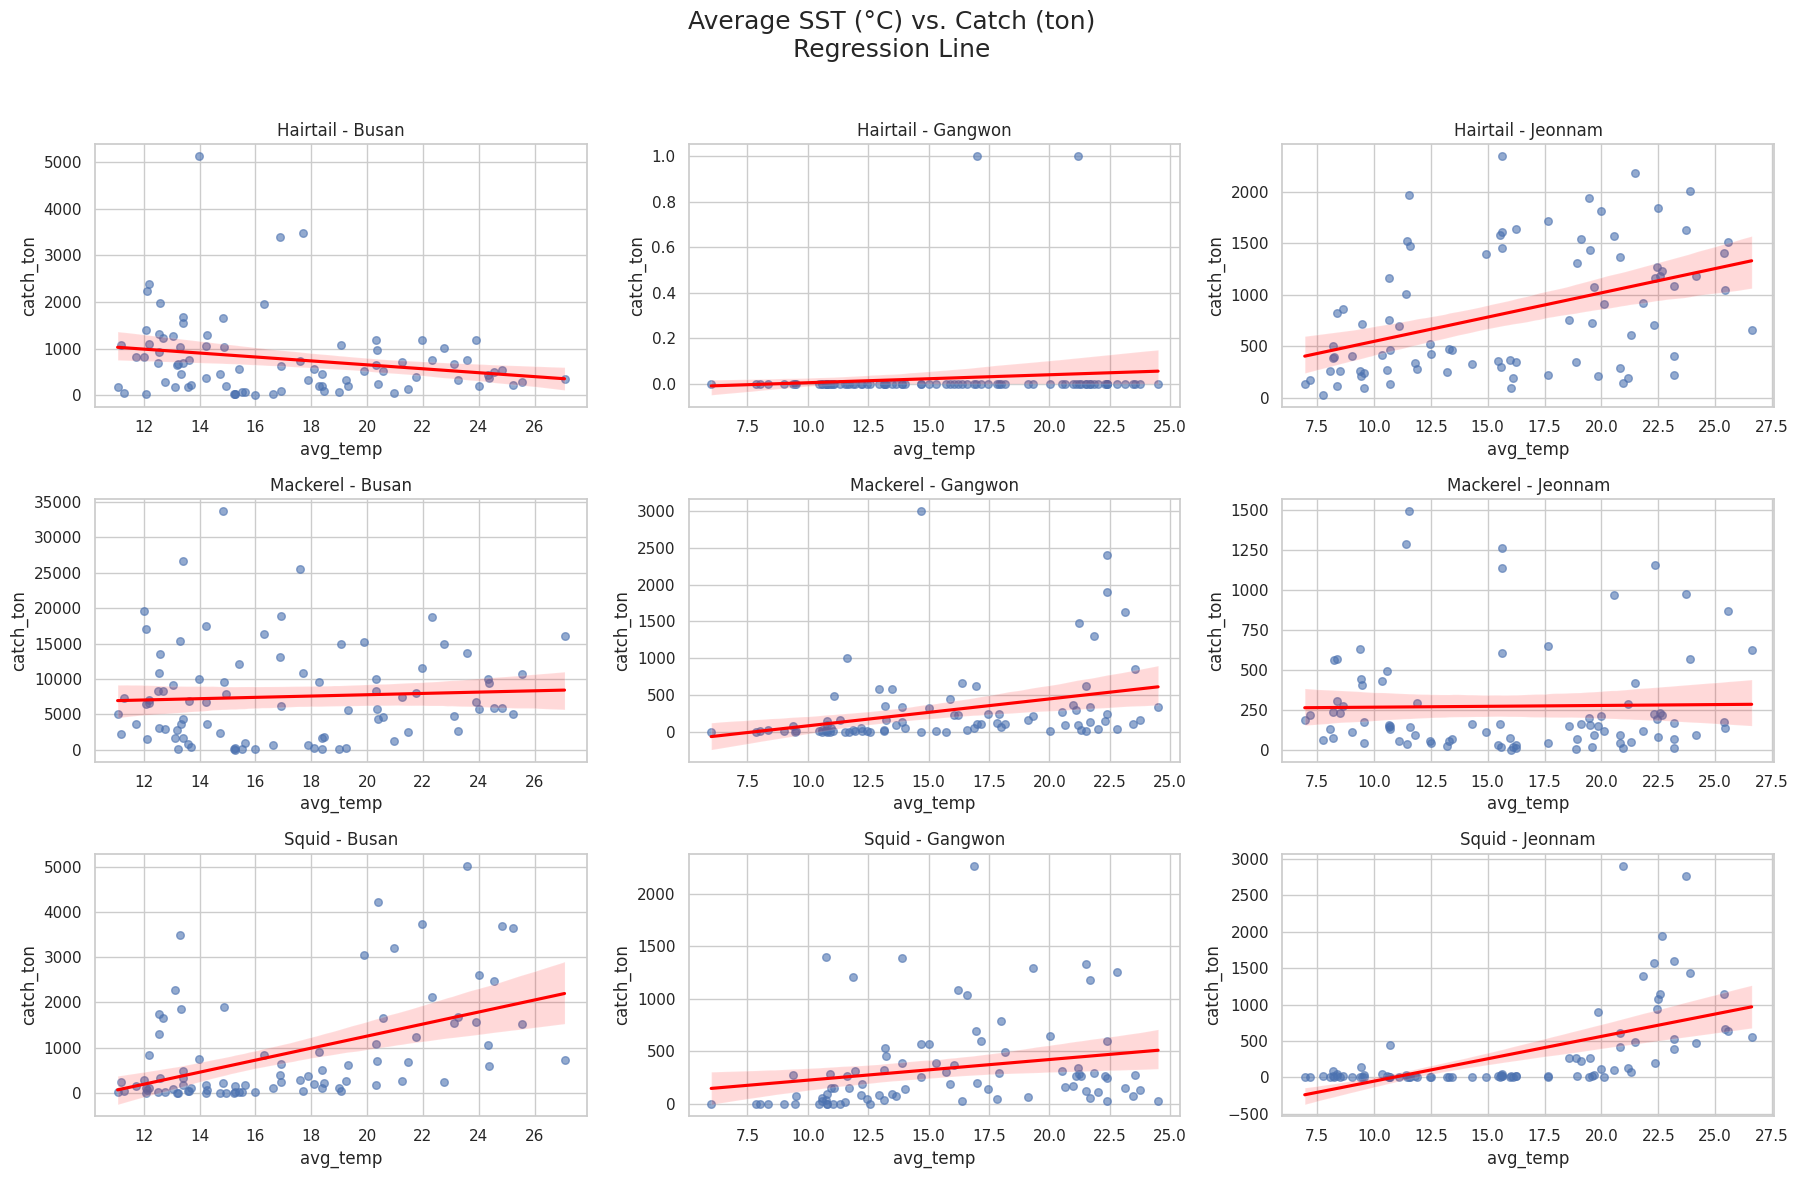

In [ ]:
# 시각화 할 어종 및 지역 리스트
species_types = ['hairtail', 'mackerel', 'squid']
regions = ['busan', 'gangwon', 'jeonnam']

# 서브플롯 틀 만들기
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
fig.suptitle('Average SST (°C) vs. Catch (ton)\nRegression Line', fontsize=18)

# 그리드 순회
for i, species in enumerate(species_types):
    for j, region in enumerate(regions):
        ax = axes[i][j]

        # 어종 및 지역 필터링
        df_filtered = merged_df[(merged_df['species'] == species) & (merged_df['region'] == region)]

        # 시각화
        sns.regplot(
            data=df_filtered,
            x='avg_temp',
            y='catch_ton',
            ax=ax,
            scatter_kws={'s': 30, 'alpha': 0.6},
            line_kws={'color': 'red'}
        )

        # 제목 설정
        ax.set_title(f'{species.capitalize()} - {region.capitalize()}', fontsize=12)
        ax.set_xlabel('avg_temp')
        ax.set_ylabel('catch_ton')

# 레이아웃 정리
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

**분석**:

- **갈치 (hairtail)**
    - 부산: 전반적으로 수온 증가에 따라 어획량은 오히려 감소하는 경향. 고수온에 따른 어장 이동 또는 수온 민감도 가능성.
    - 강원: 수온 상승에 따라 미세한 증가 경향 보이나 분포가 워낙 좁아서 뚜렷한 해석 어려움
    - 전남: 수온 상승에 따라 어획량이 증가하는 경향

- **고등어 (mackerel)**
    - 부산: 수온 상승에 따라 어획량이 증가하는 완만한 양의 경향. 전반적인 수온 상승 시에 고등어 조업량 증가 가능성 시사.
    - 강원: 양의 경향이 있지만 비교적 산포가 커서 뚜렷한 경향성은 제한적
    - 전남: 거의 flat한 경향. 수온 변화에 따른 민감도 낮음.

- **오징어 (squid)**
    - 부산: 수온 상승에 따라 어획량이 증가하는 경향
    - 강원: 미미한 양의 경향. 수온 변화폭이 좁고 산포도 크기 때문에 확신 어려움.
    - 전남: 수온 상승 시 어획량 증가 경향. 일부 이상치 영향도 고려.

---

**결론**:

- **시차를 고려하지 않은 상태에서 “수온이 높은 시점에 어획량이 높은가?“를 보는 것이므로, 계절성 영향이 많이 반영됨**
- 산포도가 전체적으로 크고 이상치가 다수 존재하므로 해석 시 유의
- 이후 시차 상관 분석 및 연도별 변화폭 분석과 비교하여 종합적으로 해석하는 것이 중요

#### **시차를 고려한 시계열형 상관 분석**

##### 1) **단기 영향 시차 상관 분석**

- 수온 변화가 n개월 후 어획량에 어떤 영향을 미치는지 확인
    - ***“수온이 높았던 시점으로부터 n개월 후, 어획량이 증가(또는 감소)했는가?”***
- 수온 변화 후, 어획량의 단기 반응 민감도 확인
- 방법:
    - 기준이 되는 월별 수온과 어획량 데이터를 사용
	- 수온 시계열은 그대로 두고, 어획량 시계열을 0~6개월까지 뒤로 이동시키며
	- 매 시차(lag)별로 피어슨 상관계수와 p-value 계산
- 즉, 모든 연도에 대해 "특정 연도의 특정 월 수온"과 "같은 연도의 그로부터 n개월 뒤 어획량"을 짝지어서 전체 연도에 걸친 데이터 쌍들을 모은 다음, 그 전체 쌍을 기반으로 피어슨 상관계수와 p-value를 계산하는 것

In [ ]:
def calc_lagged_corr(df, max_lag):
    result = {'lag': [], 'corr': [], 'pval': []}

    for lag in range(0, max_lag + 1):
        # 수온은 기준 날짜, 어획량은 lag 만큼 미래 날짜로 shift
        df_shifted = df.copy()
        df_shifted['catch_ton'] = df_shifted['catch_ton'].shift(-lag)

        # NaN 제거
        df_clean = df_shifted.dropna(subset=['avg_temp', 'catch_ton'])

        corr, pval = pearsonr(df_clean['avg_temp'], df_clean['catch_ton'])
        result['lag'].append(lag)
        result['corr'].append(round(corr, 3))
        result['pval'].append(round(pval, 6))

    return pd.DataFrame(result)

In [ ]:
def plot_lagged_corr(results_dict, max_cols=3):
    total = len(results_dict)
    ncols = max_cols
    nrows = math.ceil(total / ncols)

    fig, axs = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), sharex=True, sharey=True)
    axs = axs.flatten()

    for idx, ((sp, rg), df) in enumerate(results_dict.items()):
        ax = axs[idx]
        ax.plot(df['lag'], df['corr'], marker='o', linestyle='-')
        ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
        ax.set_title(f'{sp.capitalize()} - {rg.capitalize()}')
        ax.set_xlabel('Lag (months)')
        ax.set_ylabel('Correlation')

    # 빈 subplot 제거
    for j in range(idx + 1, len(axs)):
        fig.delaxes(axs[j])

    fig.suptitle('Lagged Correlation by Species and Region', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

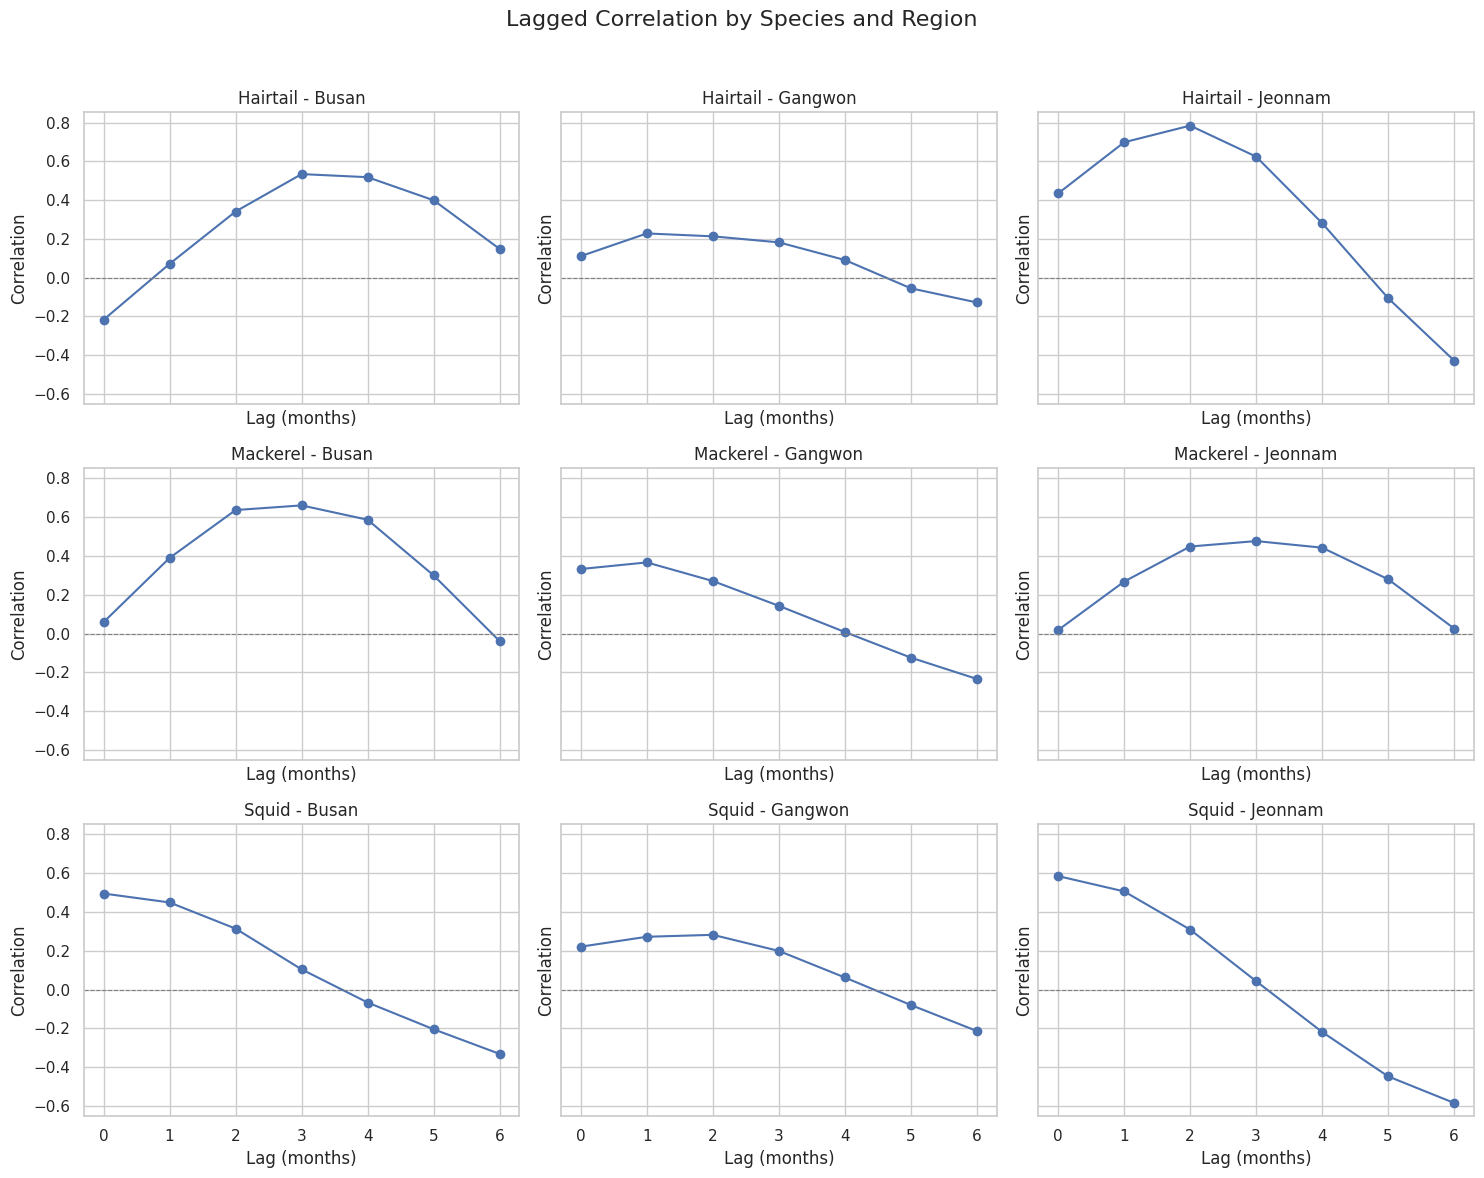

In [ ]:
# 설정값
max_lag = 6
species_list = merged_df['species'].unique()
region_list = merged_df['region'].unique()

# 결과 저장용 딕셔너리
lagged_corr_results = {}

# 루프: 분석 + 결과 저장
for sp in species_list:
    for rg in region_list:
        temp = merged_df[(merged_df['species'] == sp) & (merged_df['region'] == rg)].copy()
        temp = temp.sort_values('date')

        if len(temp) < max_lag + 5:
            continue

        result_df = calc_lagged_corr(temp, max_lag=max_lag)
        lagged_corr_results[(sp, rg)] = result_df

# 서브플롯 시각화
plot_lagged_corr(lagged_corr_results)

# 결과 요약 DataFrame 생성
summary_df = []
for (sp, rg), df in lagged_corr_results.items():
    for i in range(len(df)):
        summary_df.append({
            'species': sp,
            'region': rg,
            'lag': df.loc[i, 'lag'],
            'corr': df.loc[i, 'corr'],
            'pval': df.loc[i, 'pval']
        })

summary_df = pd.DataFrame(summary_df)

summary_df.to_csv('lagged_corr_summary.csv', index=False)

**분석**:

- **갈치 (hairtail)**
    - 부산: 수온 상승 후 약 3개월 시점에 어획량 증가 경향이 유의하게 나타남. (상관계수 = 0.534, p-value = 0.000000)
    - 강원: 수온 변화와 어획량 간 약한 양의 상관. 1개월 시차에서 유의미. (상관계수 = 0.258, p-value = 0.048281)
    - 전남: 매우 강한 양의 상관. 수온 상승 2개월 후 어획량 증가 패턴 뚜렷. (상관계수 = 0.738, p-value = 0.000000)

- **고등어 (mackerel)**
    - 부산: 수온 변화가 3개월 뒤 어획량에 강한 영향을 미침. (상관계수 = 0.640, p-value = 0.000000)
    - 강원: 수온 상승이 1개월 후 어획량 증가로 이어지는 경향. 유의미함. (상관계수 = 0.361, p-value = 0.003799)
    - 전남: 수온이 상승한 뒤 3개월 시점에 어획량이 증가하는 경향. (상관계수 = 0.475, p-value = 0.000021)

- **오징어 (squid)**
    - 부산: 수온과 어획량이 동시 발생하며 높은 양의 상관관계가 있음. (상관계수 = 0.270, p-value = 0.037112)
    - 강원: 수온 변화 직후 어획량과 약한 양의 상관 존재. (상관계수 = 0.258
, p-value = 0.048281)
    - 전남: 수온과 어획량 사이 즉시 반응 관계 존재. 강한 양의 상관. (상관계수 = 0.495, p-value = 0.000003)

→ **갈치와 고등어의 경우**, 주요 조업지인 남해(부산, 전남)에서 일반적으로 기온이 높은 여름철 수온 상승 이후 약 2 - 3개월 시차를 두고 어획량이 증가하는 경향을 보임

⇒ **이는 실제 조업 시기(갈치: 8월 ~ 11월, 고등어: 9월 ~ 이듬해 2월)와 유사한 시점으로, 수온 변화가 이후 조업 성과에 영향을 줄 수 있음을 시사**

→ **오징어의 경우**, 수온이 변한 그 달에 어획량도 즉각적으로 반응하는 양상이 뚜렷하게 나타남

⇒ **이는 오징어가 회유성이 크고 환경 변화에 민감하게 반응하는 어종이라는 점과 일치하며, 갑작스러운 수온 상승이 이동 또는 산란 행동에 영향을 미쳐 어획량에도 곧바로 반영된 것으로 해석할 수 있음**

---

**결론**:

- 본 분석은 수온 변화에 대한 **단기 반응 민감도**를 파악하기 위한 보조 분석으로, “최근 수온이 상승했다면, 곧 어획량도 증가할 수 있는가?”라는 질문에 대한 탐색적 근거를 제시함

- 단, 이는 **계절성 변동에 따른 반응 중심**이며, **기후 변화 등 장기 추세와 직접적으로 연결짓기는 어렵다**는 점에서 한계가 있음

##### 2) **장기 지연 시차 상관 분석**

- 연 단위 수온 변화와 어획량 간의 시차 관계를 파악

→ 이때 사용하고자 하였던 수온은 '연 평균 수온'인데, 중요한 수온 패턴(예: 여름 급등, 겨울 급감, 계절별 극단값)을 다 지워버리는 문제가 있음

→ 지역・시기별 수온 변화 추세 시각화에서 확인한 "양극화"의 경향은 연평균을 내면 서로 상쇄돼서 평균값에선 잘 보이지 않게 되고, 결국 어획량과의 상관도 흐릿하게 나올 수 있음

⇒ **주요 월 평균 수온으로 연도별 비교하고, 연도별 변화폭 기반 분석으로 방향 수정**

---

- 어종별·지역별 연도별 수온 변화폭과 연도별 어획량 변화폭 간의 상관 분석

- 주요 조업 시기: 어종별 수온 및 어획량을 비교할 월 범위를 다르게 지정

- 연도별 변화폭: 수온과 어획량 각각에 대해 (올해 - 작년) 차이 계산

- 상관관계: 변화폭 간의 피어슨 상관계수 계산

In [ ]:
# species-region 조합별로 데이터프레임 생성해서 globals()에 저장
for sp in species_list:
    for rg in region_list:
        temp_df = merged_df[(merged_df['species'] == sp) & (merged_df['region'] == rg)].copy()
        temp_df = temp_df.sort_values('date').reset_index(drop=True)

        var_name = f'df_{sp}_{rg}'

        globals()[var_name] = temp_df

In [ ]:
import pandas as pd
from scipy.stats import pearsonr

# 어종별 주요 조업 시기 설정
fishing_months = {
    'hairtail': [8, 9, 10, 11],
    'mackerel': [9, 10, 11, 12],
    'squid': [7, 8, 9, 10, 11, 12]
}

# 결과 저장용 리스트
results = []

# 어종별, 지역별 분석
for sp in ['hairtail', 'mackerel', 'squid']:
    for rg in ['busan', 'gangwon', 'jeonnam']:
        # 해당 데이터프레임 불러오기
        df = globals()[f'df_{sp}_{rg}'].copy()

        # 필요한 열만 사용
        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df = df[df['month'].isin(fishing_months[sp])]

        # 연도별 평균 수온, 어획량 계산
        grouped = df.groupby('year').agg({
            'avg_temp': 'mean',
            'catch_ton': 'sum'
        }).reset_index()

        # 변화폭 계산 (올해 - 전년도)
        grouped['temp_diff'] = grouped['avg_temp'].diff()
        grouped['catch_diff'] = grouped['catch_ton'].diff()

        # 결측 제거
        grouped_clean = grouped.dropna()

        # 상관계수 계산
        corr, pval = pearsonr(grouped_clean['temp_diff'], grouped_clean['catch_diff'])

        # 결과 저장
        results.append({
            'species': sp,
            'region': rg,
            'corr': round(corr, 3),
            'pval': round(pval, 6),
            'n_samples': len(grouped_clean)
        })

# 결과 출력
result_df = pd.DataFrame(results)
print(result_df)

    species   region   corr      pval  n_samples
0  hairtail    busan  0.119  0.822354          6
1  hairtail  gangwon  0.559  0.249105          6
2  hairtail  jeonnam  0.393  0.440612          6
3  mackerel    busan  0.407  0.423193          6
4  mackerel  gangwon -0.274  0.599032          6
5  mackerel  jeonnam  0.692  0.127701          6
6     squid    busan  0.650  0.161883          6
7     squid  gangwon -0.686  0.132089          6
8     squid  jeonnam  0.272  0.602254          6


**분석**:

- 상관계수 자체만 보면 0.6 ~ 0.7대의 양의 상관계수가 꽤 높은 편이지만, p-value가 전반적으로 커서 유의미한 결과라고 보긴 어려움

→ **이는 표본이 작아서 생기는 흔한 문제**

- 오징어-강원처럼 -0.686으로 강한 음의 상관을 보이는 조합도 있음

---

**결론**:

- 전체적으로 **"수온 변화폭이 어획량 변화폭과 함께 움직이긴 한다"**는 **가능성은 보이나, 확신할 수는 없음**

In [ ]:
# 어종별 주요 조업 시기 설정
fishing_months = {
    'hairtail': [8, 9, 10, 11],
    'mackerel': [9, 10, 11, 12],
    'squid': [7, 8, 9, 10, 11, 12]
}

results = []

for sp in ['hairtail', 'mackerel', 'squid']:
    for rg in ['busan', 'gangwon', 'jeonnam']:
        # 월별 데이터프레임 불러오기
        df = globals()[f'df_{sp}_{rg}'].copy()

        df['year'] = df['date'].dt.year
        df['month'] = df['date'].dt.month
        df = df[df['month'].isin(fishing_months[sp])]

        # 연도별 평균 수온, 어획량 계산
        yearly = df.groupby('year').agg({
            'avg_temp': 'mean',
            'catch_ton': 'sum'
        }).reset_index()

        # 변화폭 계산
        yearly['temp_diff'] = yearly['avg_temp'].diff()
        yearly['catch_diff'] = yearly['catch_ton'].diff()

        # 극단적 변화폭만 추출: 상위 20%만 사용
        threshold = yearly['temp_diff'].abs().quantile(0.2)
        extreme = yearly[yearly['temp_diff'].abs() >= threshold].dropna()

        if len(extreme) >= 3:  # 샘플 너무 적으면 제외
            corr, pval = pearsonr(extreme['temp_diff'], extreme['catch_diff'])
            results.append({
                'species': sp,
                'region': rg,
                'corr': round(corr, 3),
                'pval': round(pval, 6),
                'n_samples': len(extreme)
            })
        else:
            results.append({
                'species': sp,
                'region': rg,
                'corr': None,
                'pval': None,
                'n_samples': len(extreme)
            })

# 결과
result_df = pd.DataFrame(results)
print(result_df)

    species   region   corr      pval  n_samples
0  hairtail    busan  0.121  0.846254          5
1  hairtail  gangwon  0.567  0.318552          5
2  hairtail  jeonnam  0.387  0.519536          5
3  mackerel    busan  0.976  0.004383          5
4  mackerel  gangwon -0.248  0.687102          5
5  mackerel  jeonnam  0.644  0.240423          5
6     squid    busan  0.640  0.244594          5
7     squid  gangwon -0.783  0.117124          5
8     squid  jeonnam  0.885  0.046186          5


**보조 분석**:

- 극단적 변화폭 기반 상관 분석 (상위 20% 변화폭 기준)

- 일부 어종-지역에서 높은 상관계수 및 유의수준 관측
    - 고등어 - 부산: 상관계수 0.976, p-value 0.004
    - 오징어 - 전남: 상관계수 0.885, p-value 0.046
    - 그 외 대부분 조합은 유의수준에 도달하지 못함

---

**결론**:

- **극단적 수온 변화가 어획량 변화에 영향을 줄 가능성 시사**

- **다만, 표본 수의 한계로 신중한 해석 필요**

### 4. 시계열 추이 비교
- 목표: 연월별 변화에서 비슷한 패턴 여부 확인
    - 수온과 어획량을 동일 축에 맞춰 시계열로 비교

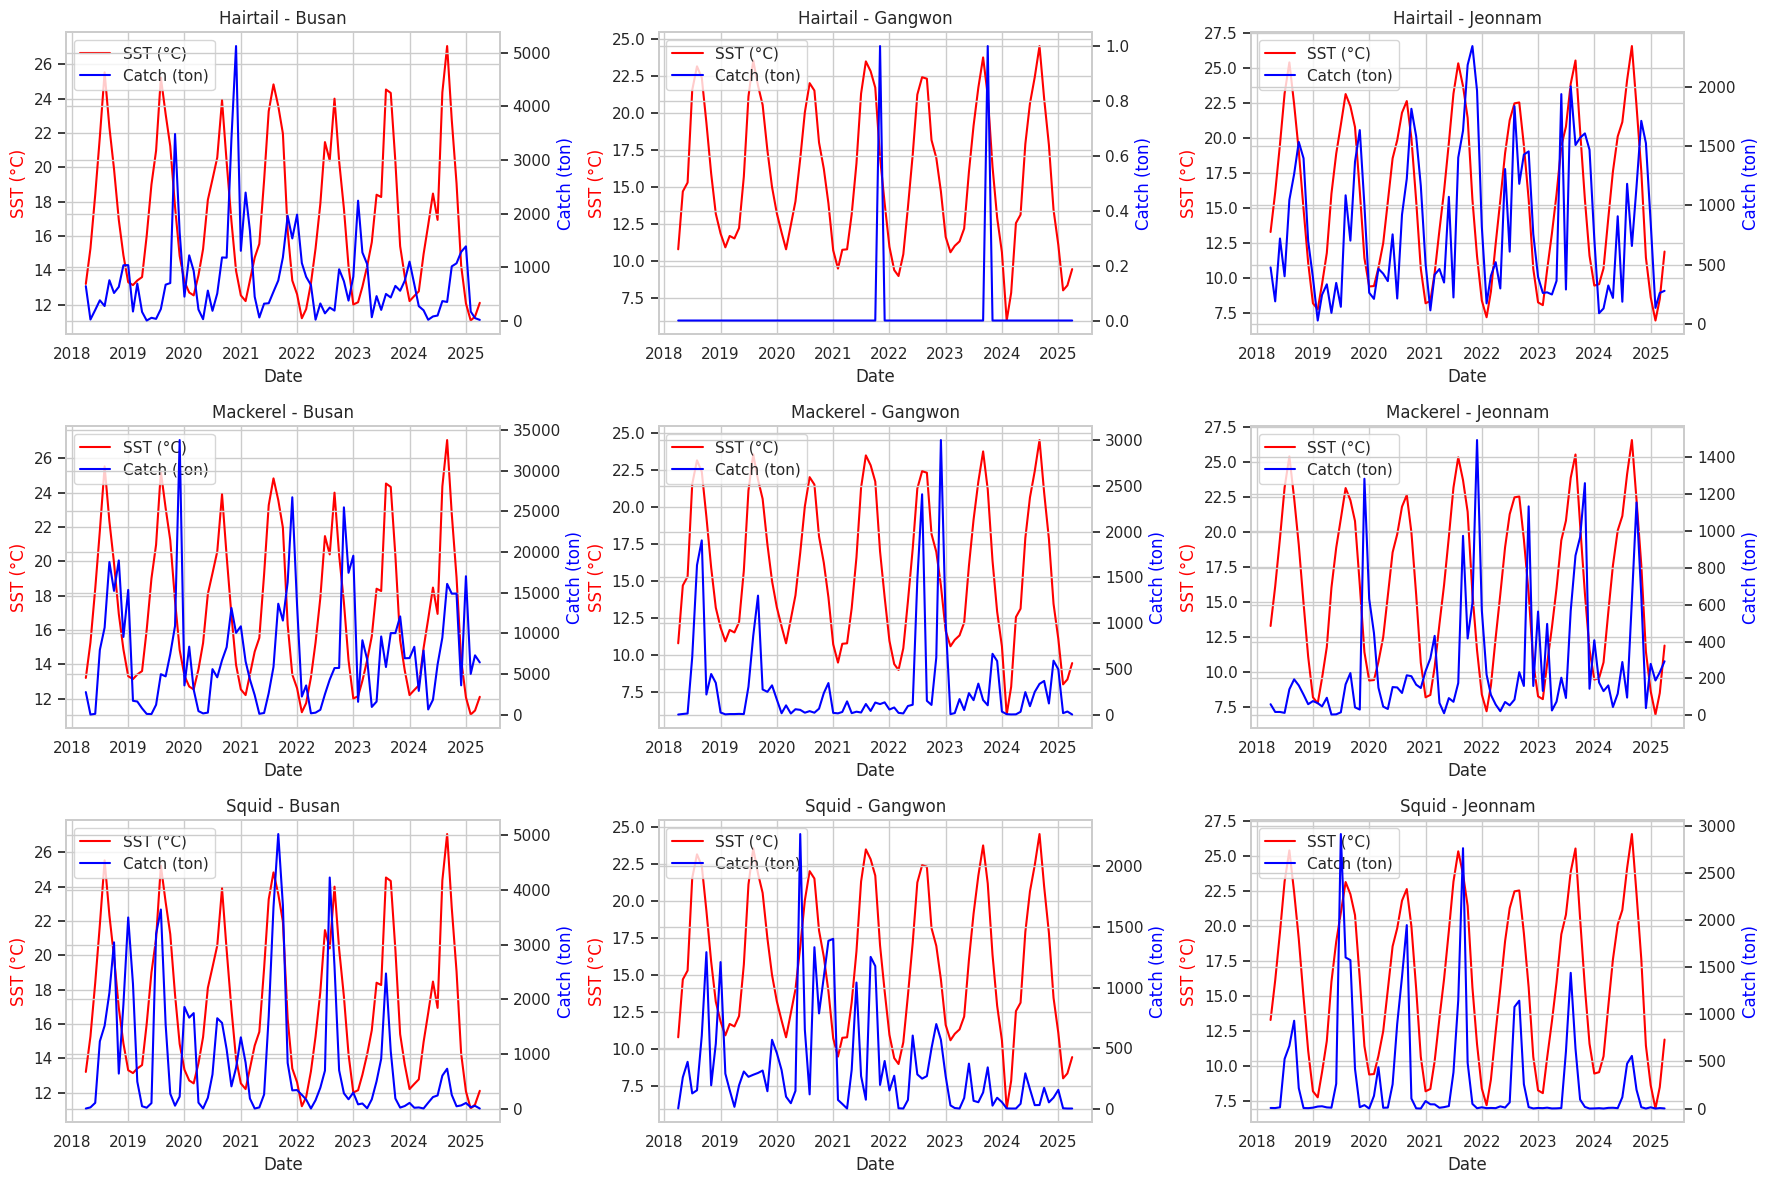

In [ ]:
species_region_list = [
    ('hairtail', 'busan'),
    ('hairtail', 'gangwon'),
    ('hairtail', 'jeonnam'),
    ('mackerel', 'busan'),
    ('mackerel', 'gangwon'),
    ('mackerel', 'jeonnam'),
    ('squid', 'busan'),
    ('squid', 'gangwon'),
    ('squid', 'jeonnam')
]

plt.figure(figsize=(18, 12))

for idx, (sp, rg) in enumerate(species_region_list, 1):
    df = merged_df[(merged_df['species'] == sp) & (merged_df['region'] == rg)].copy()
    df = df.sort_values('date').reset_index(drop=True)

    ax = plt.subplot(3, 3, idx)
    ax2 = ax.twinx()

    ln1 = ax.plot(df['date'], df['avg_temp'], color='red', label='SST (°C)')
    ln2 = ax2.plot(df['date'], df['catch_ton'], color='blue', label='Catch (ton)')

    ax.set_title(f"{sp.capitalize()} - {rg.capitalize()}")
    ax.set_xlabel('Date')
    ax.set_ylabel('SST (°C)', color='red')
    ax2.set_ylabel('Catch (ton)', color='blue')

    # 범례 하나로 합치기
    lns = ln1 + ln2
    labels = [l.get_label() for l in lns]
    ax.legend(lns, labels, loc='upper left')

plt.tight_layout()
plt.show()

**분석**

- **수온 (SST, 빨간선)**
    - 계절성 뚜렷 — 매년 비슷한 패턴 (여름철 상승, 겨울철 하강)
    - 일부 해에 여름철 피크가 조금씩 높아지는 양상은 있음. 아주 장기적인 온난화 느낌은 크진 않지만 일부 양극화 징후 존재.

- **어획량 (Catch, 파란선)**
	- 명확한 계절성은 덜함. 상대적으로 변동폭 크고, 연도 간 차이 심함.
	- 특히 고등어 부산, 오징어 부산 등 일부 구간에서 여름철 이후 어획량 증가가 수온 피크 이후에 따라가는 듯한 구간 보임
    
    → **앞서 수행한 단기 지연 시차 분석 결과와 일치하는 부분**

- 전체적으로 보면 계절성 패턴 자체는 수온 ↔ 어획량 간 큰 시간 차 없이 맞물리는 구간도 존재하지만, 장기적으로 수온 상승이 꾸준히 어획량에 영향을 준다기보다는 단기적 수온 급변 에 따른 어획량 반응이 더 눈에 띄는 경우가 있음

---

**결론**

- **수온과 어획량 간의 관계는 매우 복합적**이며 **계절성, 어종 특성, 환경 민감도 등이 동시에 작용한다**는 것을 시사함


## Conclusion

**통합 해석**

수온 변화가 어획량에 미치는 영향은 단순하지 않으며 복합적인 생태적 요인이 작용.

계절성 패턴과 어종의 서식 특성, 환경 민감도, 회유 행동 등이 동시 작용하여 어획량 변화로 나타남.

특히 단기 수온 급변 상황에서 어획량이 민감하게 반응하는 경우가 종종 관측됨.

단, 장기 기후 변화와의 직접적 연계성은 이번 분석 범위와 데이터 한계상 제한적임.

### **가설 검증 결과**

> 가설 1. *수온 변화는 어종 이동과 분포에 영향을 미친다.*

✅ **지지됨**
- 어종별 선호 수온대가 명확히 구분됨 (갈치·고등어: 1216°C / 오징어: 2225°C)
- 단기 수온 변화 이후 어획량 반응 패턴 확인 → 서식지 이동 가능성의 간접적 신호
- 다만, 실제 지리적 이동 경로 데이터는 부족 → 정확한 이동 범위 추정은 제한적

> 가설 2. *수온이 높아질수록 어종이 북상한다.*

⚠️ **일부 지지, 그러나 제한적**
- 강원(북부) 지역에서 여름철 이후 갈치·고등어 어획이 소폭 증가하는 경향은 관측됨 → 북상 가능성을 일부 시사
- 그러나 현 데이터는 수온 변화 시 북상 여부를 직접 추적하기엔 한계 존재
- 전반적 패턴은 “이동”보다는 시기적 출현 변화에 가까움

> 가설 3. *수온이 높아질수록 전통적 조업 지역에서의 어획량이 줄어든다.*

❌ **부분 지지되나, 전반적으로 지지되지 않음**
- 갈치 - 부산: 고수온기 어획량 감소 경향 → 수정 가설 지지
- 고등어·오징어 - 부산: 수온 상승 후 어획량 증가 경향 → 수정 가설과 반대
- 일부 북상 가능성을 시사하는 경우가 있으나, 대부분 어종은 기존 조업 지역에서도 수온 상승에 긍정적 반응
- **어종 특성(회유성, 환경 민감도 등)**이 조업 성과 변화에 큰 영향을 미침.